1.   데이터 불러오기

2.   원하는 결과값의 분포도 확인
  - 한쪽으로 치우쳐져있다면 log화 해주기

3. Null 값 처리

4. 텍스트로 이루어진 데이터들을 벡터화 시켜주기
  - CountVetorizer or TfidfVetorizer

5. 나머지 Feature들에 해당하는 데이터들도 incoding 해주기
  - LabelBinarizer or Labelincoding or One-Hot-incoding

6. 각각의 데이터들 병합하기
  -   scipy의 sparse.hstack
  -   sparse 는 가로방향으로 합치는것을 의미한다.
  -   sparse.vstack 이용하면 세로 방향으로 합쳐진다.

7. 합친다음 .tocsr()을 이용하여 CSR Sparse matrix 로 바꿔준다.

8. 합친 데이터를 이용하여 Ridge, LGBMRegressor를 이용하여 학습하기



In [1]:
import pandas as pd

mercari = pd.read_csv('/content/drive/MyDrive/인프런 - 파이썬 머신러닝 완벽가이드/Files/Mercari 텍스트 분석/Mercari_train.tsv', sep='\t')
mercari.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
mercari.drop('train_id', axis=1, inplace=True)
mercari.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1476208 non-null  object 
 3   brand_name         849853 non-null   object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482531 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 79.2+ MB


# Price 값 분포도 확인 및 Log 화

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


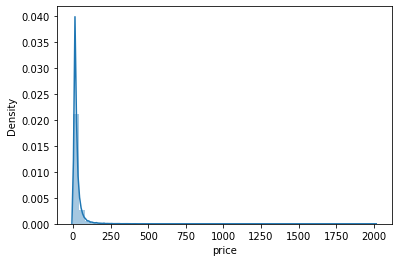

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(mercari['price'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


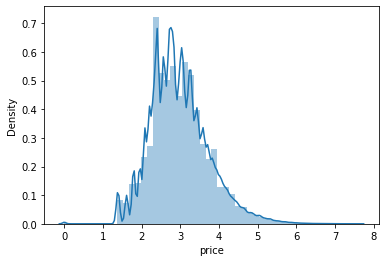

In [6]:
import numpy as np

price_log = np.log1p(mercari['price'])
sns.distplot(price_log)

In [7]:
mercari['price'] = price_log

# category_name를 분류

In [8]:
def splits(text):
  try:
    return text.split('/')
  except:
    return ['Nan' , 'Nan' , 'Nan']

mercari['cat_first'], mercari['cat_second'], mercari['cat_third'] = zip(*mercari['category_name'].apply(lambda x : splits(x)))

In [9]:
mercari.head(3)

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_first,cat_second,cat_third
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse


# Null 값 처리

In [18]:
mercari = mercari.fillna(value='Other_Null')

In [19]:
mercari.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1482535 non-null  object 
 3   brand_name         1482535 non-null  object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482535 non-null  object 
 7   cat_first          1482535 non-null  object 
 8   cat_second         1482535 non-null  object 
 9   cat_third          1482535 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 113.1+ MB


# 피처 인코딩과 피처 벡터화

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

CountV = CountVectorizer(max_features=30000)
Name_CV = CountV.fit_transform(mercari['name'])

TfV = TfidfVectorizer(stop_words='english', max_features=50000, ngram_range=(1,3))
item_desc_TfV = TfV.fit_transform(mercari['item_description'])

print(Name_CV.shape, item_desc_TfV.shape)

(1482535, 30000) (1482535, 50000)


In [23]:
import gc
gc.collect()

504

In [24]:
from sklearn.preprocessing import LabelBinarizer

lb_item = LabelBinarizer(sparse_output = True)
item_lb = lb_item.fit_transform(mercari['item_condition_id'])
lb_brand = LabelBinarizer(sparse_output = True)
brand_lb = lb_brand.fit_transform(mercari['brand_name'])
lb_ship = LabelBinarizer(sparse_output = True)
ship_lb = lb_ship.fit_transform(mercari['shipping'])
lb_first = LabelBinarizer(sparse_output = True)
first_lb = lb_first.fit_transform(mercari['cat_first'])
lb_second = LabelBinarizer(sparse_output = True)
second_lb = lb_second.fit_transform(mercari['cat_second'])
lb_third = LabelBinarizer(sparse_output = True)
third_lb = lb_third.fit_transform(mercari['cat_third'])

In [25]:
import gc
gc.collect()

95

In [28]:
from scipy.sparse import hstack

sparse_stack_list = (Name_CV, item_desc_TfV, item_lb, brand_lb, ship_lb, first_lb, second_lb, third_lb)

feature_stack = hstack(sparse_stack_list).tocsr()
print(type(feature_stack), feature_stack.shape)

gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 85812)


700

In [29]:
def rmsle(y, y_pred):
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred),2)))

def get_org_rmsle(y_test, preds):
  preds_exp = np.expm1(preds)
  y_test_exp = np.expm1(y_test)

  org_rmsle = rmsle(y_test_exp, preds_exp)
  return org_rmsle

In [34]:
from sklearn.model_selection import train_test_split

def model_train_test_split(model, sparse_list):
  sparse_stack = hstack(sparse_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(sparse_stack, mercari['price'], test_size=0.2)

  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  gc.collect()

  return y_test, preds

In [35]:
from sklearn.linear_model import Ridge

RD = Ridge(solver = "lsqr", fit_intercept=False)

sparse_lists = (Name_CV, item_lb, brand_lb, ship_lb, first_lb, second_lb, third_lb)
y_test, RD_preds = model_train_test_split(model=RD ,sparse_list=sparse_lists)
print("RMSLE (except item_description) : ", get_org_rmsle(y_test, RD_preds))

RMSLE (except item_description) :  0.5023271841222796


In [38]:
sparse_lists = (Name_CV, item_desc_TfV, item_lb, brand_lb, ship_lb, first_lb, second_lb, third_lb)
y_test, RD_preds = model_train_test_split(model=RD ,sparse_list=sparse_lists)
print("RMSLE (No except) : ", get_org_rmsle(y_test, RD_preds))

gc.collect()

RMSLE (No except) :  0.47139896843094053


0

In [40]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125)

sparse_lists = (Name_CV, item_desc_TfV, item_lb, brand_lb, ship_lb, first_lb, second_lb, third_lb)
y_test, lgbm_preds = model_train_test_split(model = lgbm, sparse_list = sparse_lists)
print("LGBM RMSLE : ", get_org_rmsle(y_test, lgbm_preds))

LGBM RMSLE :  0.4573947684867168


In [50]:
preds = 0.9*lgbm_preds + 0.2*RD_preds
print("LGBM + Ridge RMSLE : ", get_org_rmsle(y_test, preds))

LGBM + Ridge RMSLE :  0.4847219842764531


In [42]:
gc.collect()

225